In [1]:
# We are creating a dataset which is based on all of the dual-task trials per block and we are ignoring the practice trials
# The dataset is built by merging the results acquired in the paper created by Chris (---link---)

# Some columns are based on the significance provided in the said paper ( & maybe image here)
# The csv files we are merging into our dataset are provided below

# -MaxDeviationPerTrial.csv
# -maxnrDigitEnteredPerPPAndPerBlockPerTrial.csv
# -numberOfVisitsTrackerPerParticipantPerBlock.csv (trial data)
# samplesOutsideTrial.csv(*)
# sdVisTime.csv(*)
# tableForMeanTimeInDigitPerPPandPerBlock.csv(*) - merge the data ber block maybe?

# We are using the payoff function values provided in the meanVisTime.csv file
# The columns marked with star could be significant and we are testing to see the results with or without the said feature

In [2]:
# We first read the data and display it
final_rows = []

import pandas as pd

data = pd.read_csv('./data.csv');

print(data.shape)

display('loaded data!')

(1920, 8)


'loaded data!'

In [3]:
# We first split the data into 8 datasets
# and we calculate the mean value for each of the dataset
# in order to see how biased the data is in terms of 
# Radius, Noise and the payoff function

split_on = ['PayOffFunction','Radius','Noise']

def split(dataSets,col):
    
    s = []
    
    for data in dataSets:
        
        if(col >= len(split_on)):
            return None
        
        values = {}
        
        for row in range(0,data.shape[ 0 ]):
            splitColumn = split_on[ col ]

            rowValue = data.iloc[ row ][ splitColumn ]
            
            if not rowValue in values:
                values[ rowValue ] = [ ]
                
            values[ rowValue ].append(row)
            
        for value in values:
            
            nextSet = []
            
            for row in values[value]:
                nextSet.append(data.iloc[ row ])
                
            s.append(pd.DataFrame(nextSet))
    res = split( s , col + 1 )
    
    if res is None:
        return s
    else: 
        return res
    
sets = [ data ]

split_sets = split(sets,0)

print('resulting length : ' +  str(len(split_sets)))


resulting length : 8


In [4]:

#We then take the top N percent of each of the sets

def get_by_split(sets,start, step, end, func):
    
    while start <= end:
    
        for dataSet in sets:
            func(start,dataSet)
            
        start = start + step

per_tick = {}

#we save all of the datasets in this variable for later use
datasets = []

#We then compute the mean for the score column for the provided dataset
def mean(current_tick,item):

    #meanVal = item['Score'].mean()
    
    #if current_tick not in per_tick:
    #    per_tick[current_tick]= []
   #     
   # per_tick[current_tick].append(meanVal)
    datasets.append(item)

get_by_split(split_sets, 1, 0.05, 1,mean)


In [5]:
from sklearn.utils import shuffle
d = []
for dataset in datasets:
    newset = shuffle(dataset)
    d.append(newset)
datasets = d

In [6]:
# We can now measure the distributions
# by testing different sizes

import matplotlib.pyplot as plt
import numpy as np

for tick_size in per_tick:
    tick_marks = np.arange(len(per_tick[tick_size]))
    fig, ax = plt.subplots()
    plt.bar(tick_marks,per_tick[tick_size])
    plt.show()

In [7]:
dictionary = {}

i = 0;
perc = 100
rowCounter = 0

print( 'there are ' + str(len(datasets)) + ' datasets' )

while(i <= 9):
    
    print('starting to aquire chunk ' + str(i))
    
    rp = []

    for next_set in datasets:
        size = int(next_set.shape[0] / perc)
        
        #starting point
        take = i * size
        start = take
        end = take + size
        next_items = next_set[start:end]
        
        frame = pd.DataFrame(next_items,columns=next_set.columns)
        rp.append(frame)
        
    dictionary[ i ] = pd.concat(rp)
    i = i + 1
    
print('done partitioning in chunks')

there are 8 datasets
starting to aquire chunk 0
starting to aquire chunk 1
starting to aquire chunk 2
starting to aquire chunk 3
starting to aquire chunk 4
starting to aquire chunk 5
starting to aquire chunk 6
starting to aquire chunk 7
starting to aquire chunk 8
starting to aquire chunk 9
done partitioning in chunks


In [8]:
# Then we split the data into training and testing sets by using the train test split function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit

def augment(func, label):
 splits = {}
 k = 0
 
 best_score = -999999
 model_y = None
 ordered_dataset = None
 print('Begin training classifier')

 for k in dictionary:
     test_set = dictionary[k]
     train_q = [test_set]
    
     for key in dictionary:
         if key == k: 
             continue
         train_q.append(dictionary[key])
        
     train_data = pd.concat(train_q)
        
     y = train_data[ label ]
     X = train_data.drop( label , 1 )
        
     indic = []
    
     for i in range(0, X.shape[0]):
        if i < test_set.shape[0]:
            indic.append(1)
        else:
            indic.append(-1)
                
     #https://stackoverflow.com/questions/31948879/using-explict-predefined-validation-set-for-grid-search-with-sklearn
     ps = PredefinedSplit(test_fold=indic)
        
     result = func(X,y,ps)
    
     if result[0] > best_score:
        best_score=result[0]
        model_y = result[1]
        ordered_dataset = result[2]
        ordered_dataset[label]=y
        
 ordered_dataset['d'] = model_y
 print('End training classifier')
    
 print('Avg speed')
 speed = ordered_dataset.loc[ordered_dataset['PayOffFunction'] == 'Speed']['d'].mean()
 acc = ordered_dataset.loc[ordered_dataset['PayOffFunction'] == 'Accuracy']['d'].mean()
 print(speed)
 print('Avg acc')
 print(acc)
 return ordered_dataset
    

In [9]:
from sklearn.svm import SVC
from sklearn.tree import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

# here be les dragons
sv = SVC(cache_size=7000)
tr = tree.DecisionTreeClassifier()
rfr = RandomForestRegressor()
lreg = LogisticRegression()

In [10]:
# Using grid search CV to tweak parameters
# We define a hyper parameter

from sklearn.model_selection import GridSearchCV

dict_grid = {
    sv: [
            {
                'C': [10], 
                'gamma' : [1],
                'kernel' : ['linear']
            }
    ],
    tr : [
            {
                #TODO:...
            }
    ],
    rfr: [
        {
            'n_estimators' : [5,10],
            
        }
    ],
    lreg: [
        {
            
        }
    ]
}

In [11]:
def work(X,y,fold):
    
 best_model = None
 best_score = -999999
    
 for score in scores:
    for algorithm in algorithms:
        grid = dict_grid[algorithm]
        clf = GridSearchCV(algorithm,grid , scoring = '%s' % score, cv = fold)
        
        clf.fit( X, y )
        
        #In short when using a linear kernel, the result is a hyperplane and it's parameters
        # are present in the weights & intercept properties of the clf object.
        
        print('score : ' + str(clf.best_score_))
        
        if(clf.best_score_ > best_score):
            best_model = clf
            best_score = clf.best_score_
            
 return (best_score,best_model.decision_function(X),X)

In [12]:
def train_regressor(X,y,grid):
     clf = GridSearchCV(rfr, grid[rfr] , scoring = 'r2')
     clf.fit(X,y)
     print(clf.best_score_)

Begin training classifier
score : 0.75
score : 0.6875
score : 0.9375
score : 0.5625
score : 0.8125
score : 0.8125
score : 0.75
score : 0.8125
score : 0.5625
score : 0.5625
End training classifier
Avg speed
0.7475833755380293
Avg acc
-0.827009129523599
Begin training regressor
0.799501530906


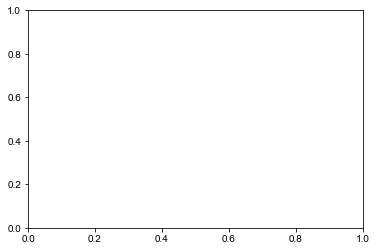

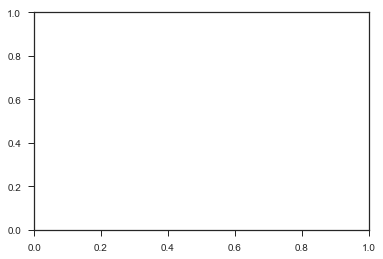

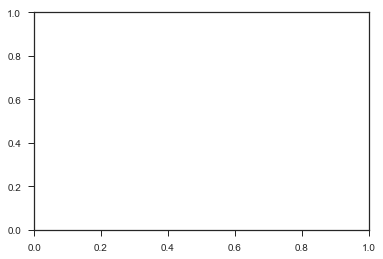

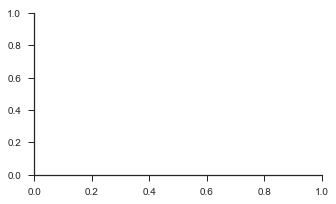

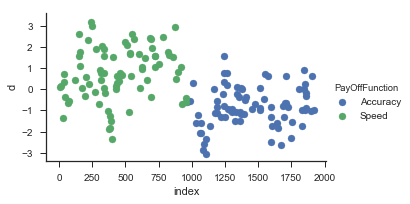

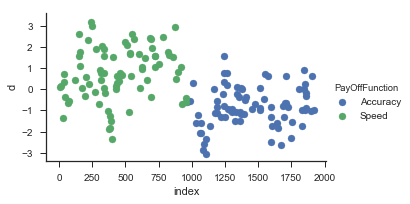

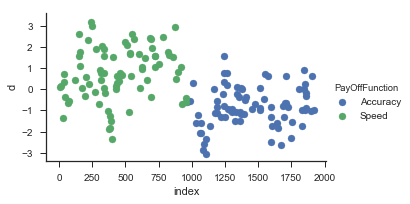

In [25]:
from sklearn.utils import shuffle
from  matplotlib import pyplot
import seaborn
seaborn.set(style='ticks')


algorithms = [sv]
scores = ['accuracy']

augmented_dataset = augment(work,'PayOffFunction')

#get the new column
yReg = augmented_dataset[ 'd' ]
xReg = augmented_dataset.drop( 'd' ,1 )

print('Begin training regressor')
x_dum = pd.get_dummies(xReg)

train_regressor(x_dum,yReg,dict_grid)

augmented_dataset['index'] = augmented_dataset.index

_func = ['Accuracy','Speed']

fg = seaborn.FacetGrid(data=augmented_dataset, hue='PayOffFunction', hue_order=_func, aspect=1.61)
fg.map(pyplot.scatter, 'index', 'd').add_legend()
plt.show()